In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
from ctapipe.io import TableLoader
import numpy as np
import astropy.units as u
from astropy.table import vstack, QTable

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib widget

In [5]:
opts = dict(load_dl2=True, load_simulated=True, load_dl1_parameters=False)


print('Reading Gammas')
with TableLoader('./build/gamma-diffuse_eval.dl2.h5', **opts) as g_loader:
    gammas = QTable(g_loader.read_subarray_events(), copy=False)
print('done')

Reading Gammas


In [6]:
print('Reading Protons')
with TableLoader('./build/proton_eval.dl2.h5', **opts) as p_loader:
    protons = QTable(p_loader.read_subarray_events(), copy=False)
print('done')

Reading Protons


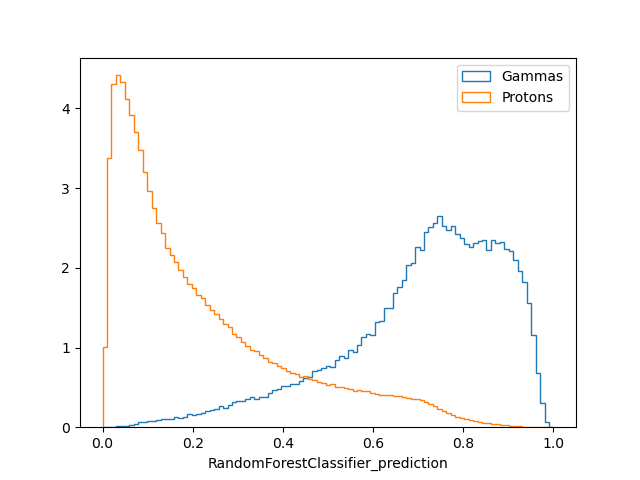

In [7]:
plt.figure()

hist_opts = dict(bins=101, range=[0, 1], histtype='step', density=True)

key = "RandomForestClassifier_prediction"
for t, label in zip((gammas, protons), ("Gammas", "Protons")):
    plt.hist(t[key], **hist_opts, label=label)

plt.xlabel(key)
plt.legend()

In [8]:
events = vstack([protons, gammas])

In [9]:
mask = events['RandomForestClassifier_is_valid']

In [10]:
fpr, tpr, threshold = roc_curve(
    events['true_shower_primary_id'][mask],
    events['RandomForestClassifier_prediction'][mask], 
    pos_label=0,
)

roc_auc = np.trapz(x=fpr, y=tpr)
roc_auc

0.9466745127105406

(-0.01, 1.01)

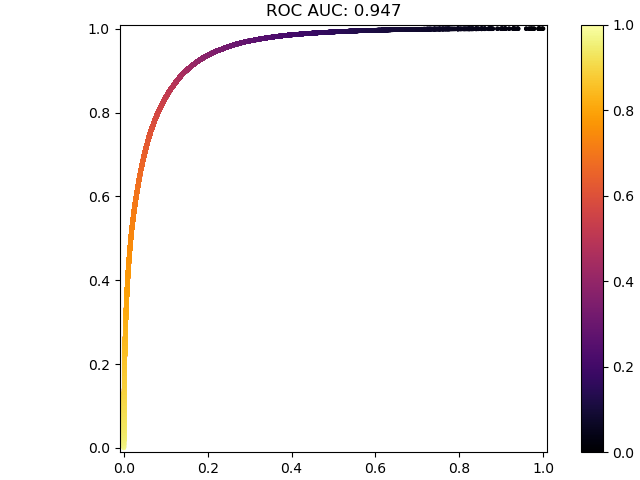

In [11]:
fig, ax = plt.subplots(constrained_layout=True)

plot = ax.scatter(
    fpr, tpr,
    c=threshold,
    cmap='inferno',
    vmin=0,
    vmax=1,
    s=5,
)

fig.colorbar(plot, ax=ax)

ax.set_title(f'ROC AUC: {roc_auc:.3f}')
ax.set_aspect(1)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

In [13]:
e_reco_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, 11)

events['bin_index'] = np.digitize(events['RandomForestRegressor_energy'].to_value(u.TeV), e_reco_bins.to_value(u.TeV))

grouped = events.group_by('bin_index')

In [14]:

roc_aucs = np.full(len(e_reco_bins) + 1, np.nan)
for idx, group  in zip(grouped.groups.keys, grouped.groups):

    mask = group["RandomForestClassifier_is_valid"]
    fpr, tpr, threshold = roc_curve(
        group['true_shower_primary_id'][mask],
        group['RandomForestClassifier_prediction'][mask], 
        pos_label=0,
    )

    roc_aucs[idx[0]] = np.trapz(y=tpr, x=fpr)
    
roc_aucs = roc_aucs[1:-1]

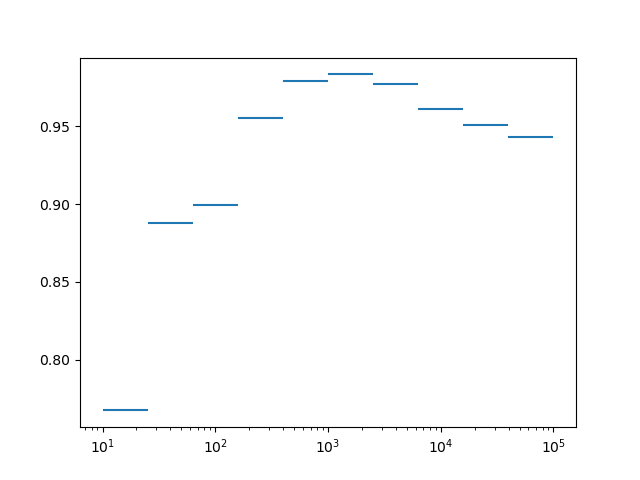

In [15]:
plt.figure()

center = 0.5 * (e_reco_bins[1:] + e_reco_bins[:-1])
width = 0.5 * np.diff(e_reco_bins) 
plt.errorbar(
    center.to_value(u.GeV),
    roc_aucs,
    xerr=width.to_value(u.GeV),
    ls='',
)

plt.xscale('log')

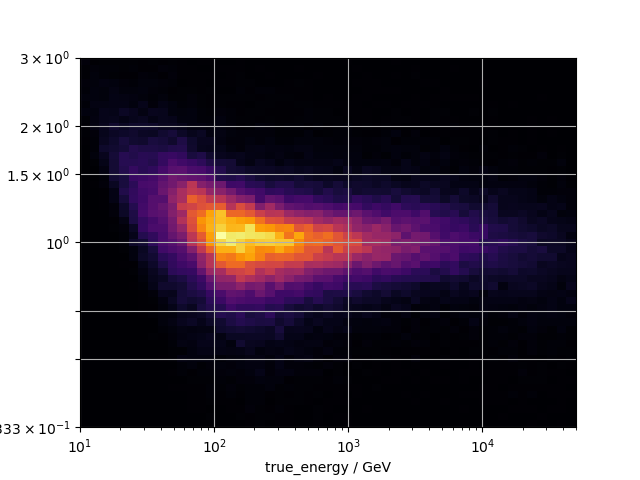

In [27]:
from matplotlib.colors import LogNorm

e_bins = np.geomspace(10 * u.GeV, 50 * u.TeV, 52)
mu_bins = np.geomspace(1/3, 3, 52)

fig, ax = plt.subplots()

ax.hist2d(
    gammas['true_energy'].to_value(u.GeV),
    (gammas['RandomForestRegressor_energy'].to_value(u.GeV) / gammas['true_energy'].to_value(u.GeV)),
    bins=[e_bins.to_value(u.GeV), mu_bins],
    cmap='inferno',
)


ax.grid()
ax.set(
    xscale='log',
    yscale='log',
    xlabel='true_energy / GeV',
    ylabel='reco_energy / true_energy',
)
ax.set_yticks(np.array([1/3, 1/2, 2/3, 1.0, 3/2, 2/1, 3/1]))
ax.set_yticks([], minor=True)
None

In [28]:
from pyirf.benchmarks import energy_bias_resolution
from astropy.table import QTable
from astropy.coordinates.angle_utilities import angular_separation

In [30]:
gammas["reco_energy"] = gammas["RandomForestRegressor_energy"]
gammas["reco_theta"] = angular_separation(
    gammas["HillasReconstructor_az"], gammas["HillasReconstructor_alt"],
    gammas["true_az"], gammas["true_alt"],
)

In [32]:
valid_mask = gammas['RandomForestRegressor_is_valid']
theta_mask = gammas["reco_theta"] < 0.3 * u.deg
prediction_mask = gammas["RandomForestClassifier_prediction"] > 0.7

mask = (
    valid_mask
    & theta_mask
    & prediction_mask
)

np.count_nonzero([valid_mask, theta_mask, prediction_mask, mask], axis=1)

array([120169,  84165,  71704,  59590])

In [39]:
bins = np.geomspace(20 * u.GeV, 100 * u.TeV, 21)
bias_resolution = QTable(energy_bias_resolution(
    gammas[mask],
    bins,
    bias_function=np.mean
))

In [40]:
bias_resolution

true_energy_low,true_energy_high,true_energy_center,bias,resolution
TeV,TeV,TeV,,
float64,float64,float64,float64,float64
0.02,0.03061811824127734,0.02530905912063867,0.5634169269055194,0.30638209198886446
0.03061811824127734,0.046873458231842004,0.03874578823655967,0.33437902278860915,0.3094383330439269
0.046873458231842004,0.07175885432600561,0.05931615627892381,0.22635343722737908,0.2557917828200623
0.07175885432600561,0.10985605433061178,0.0908074543283087,0.11540694890709899,0.20709635364702256
0.10985605433061178,0.16817928305074292,0.13901766869067736,0.03658180025980202,0.18517980630956887
0.16817928305074292,0.25746665870904467,0.2128229708798938,0.010766250530223582,0.1707563730840491
0.25746665870904467,0.39415722997700636,0.3258119443430255,-0.003082551968642849,0.16609791875571564
0.39415722997700636,0.6034176336545163,0.49878743181576135,-0.001705424311606775,0.1562816184276401


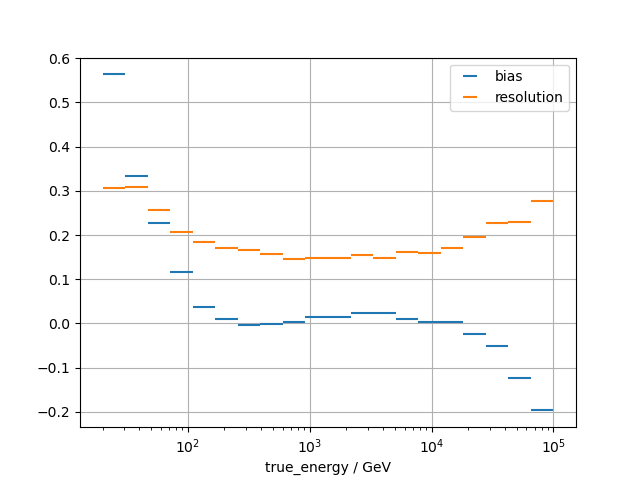

In [42]:
fig, ax = plt.subplots()


for key in ("bias", "resolution"):
    ax.errorbar(
        bias_resolution["true_energy_center"].to_value(u.GeV),
        bias_resolution[key],
        xerr=(bias_resolution["true_energy_high"] - bias_resolution["true_energy_low"]).to_value(u.GeV) / 2,
        ls='',
        label=key
    )

ax.set(
    xscale='log',
    xlabel='true_energy / GeV'
)
ax.legend()
ax.grid()